## Least squares, Richter's law and Python implementation

In this notebook we will implement the possibility to apply the Richter's law, which relates the number of earthquake events, in a given area, as a function of their magnitude, to the seismic datasets we already saw in the last notebook. 

The Richter's law has the *linear* form:

$$ \log_{10} N(M) = m\cdot M + q$$

where $N(M)$ is the number of seismic events of magnitude $M$; $m$ is the *slope* and $q$ is the *intercept* of the line expressing the law. 

Having obtained the *number* $N(M)$, for $M$ ranging in a given interval, the coefficients $m$ and $q$ will be estimated by the *least squares* method. For that, we will make use of the *numpy* function ***polyfit***. 


### Least squares

Imagine to have two lists of variables (*x* and *y*) that are supposed to be related by some law, let's say, a quadratic one; for instance:

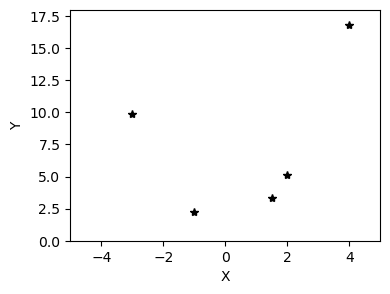

In [1]:
import matplotlib.pyplot as plt

x=[-3, -1, 1.5, 2, 4]
y=[9.9, 2.2, 3.32, 5.1, 16.8]

plt.figure(figsize=(4,3))
plt.plot(x,y, "k*")
plt.xlim(-5, 5)
plt.ylim(0, 18)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In the cell above we defined the two variables and gave their graphical representation.

Now, by looking at the plot, it is reasonable to suppose that a suitable model for $y(x)$ could be of the type: 

$$y = ax^2 + bx +c$$

where the coefficients $a,\ b$ and $c$ have some values that could be estimated by the *least squares* method. The task is very simple if the *numpy* function *polyfit* is used:

In [2]:
import numpy as np

fit = np.polyfit(x, y, 2)  # x: independent variable
                           # y: dependent variable
                           # 2: degree of the polynomium

print("Coefficients of the fit: ", fit)

Coefficients of the fit:  [0.97374075 0.006954   1.17850434]


The *polyfit* function accepts the two lists as input, plus the *degree* of the polynomial fit (2, in this example). It returns the coefficients of the fit (from the highest to the lowest power term), which have been stored in the variable *fit*. Other arguments or returned values can be optionally set or requested (see [here]( https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html) for details). 

We can use the numpy function *polyval* to compute *y* from the *fit* and a list of *x* values, as we do below: 

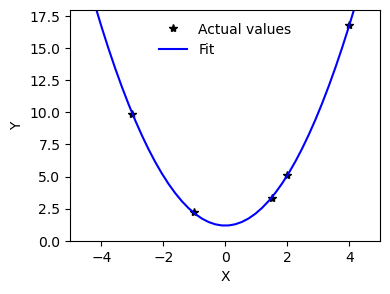

In [3]:
x_plot=np.linspace(-4.2, 4.2, 40)
y_plot=np.polyval(fit, x_plot)

plt.figure(figsize=(4,3))
plt.plot(x,y, "k*", label="Actual values")
plt.plot(x_plot, y_plot, "b-", label="Fit")
plt.xlim(-5, 5)
plt.ylim(0, 18)
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(frameon=False)
plt.show()

We can also easily estimate the error on fit:

In [4]:
sum2=np.sum((y-np.polyval(fit, x))**2)
std=np.sqrt(sum2/len(x))

print("Estimated squared error of fit: ", sum2.round(3)) 
print("Estimated error of fit:         ", std.round(3))

Estimated squared error of fit:  0.007
Estimated error of fit:          0.038


The error of fit can be also obtained by setting the keyword variable *full* to ***True*** in the arguments of the *np.polyfit* function; this provides a list of data which contains, in position 1, a *one value list* containing the *squared error* of the fit (in position 0):   

In [5]:
result=np.polyfit(x,y,2, full=True)
print("Estimated squared error of fit: ", result[1][0].round(3))

Estimated squared error of fit:  0.007


Errors on the single parameters can be estimated starting from the covariance matrix from the fit:

In [6]:
import pprint

fit, cov=np.polyfit(x, y, 2,cov=True)
print("Covariance matrix: \n")
pprint.pprint(cov)

Covariance matrix: 

array([[ 2.82951185e-05, -2.35476154e-05, -1.66020183e-04],
       [-2.35476154e-05,  1.43422069e-04,  5.14866711e-05],
       [-1.66020183e-04,  5.14866711e-05,  1.77278887e-03]])


Then the errors on parameters can be estimated as the square roots of the diagonal values of such *covariance matrix* 

In [7]:
dcov=np.diag(cov)
errors=np.sqrt(dcov)
print("Parameters:           ", fit)
print("Errors on parameters: ", errors)

Parameters:            [0.97374075 0.006954   1.17850434]
Errors on parameters:  [0.00531932 0.0119759  0.0421045 ]


## Exercise: the Richter's law

In the class *Data* previoulsy illustrated, try to implement a new method for the application of the Richter's law to the objects of the class. 

In doing that, you might need to *group* the events, whose magnitude is in a given range, in a limited number of *channels* (*bins*): you might want to use the *numpy* function ***histogram***     

In the example below, 

- we generate a list *x* of 10000 random numbers following a Poisson distribution centered on the value of 20; 
- we make a graphic histogram representation of *x* by using the *matplotlib* function *hist*, with 40 *bins*;
- we use *histogram* from the *numpy library* to group all the *x* entries in 10 *bins*, according to their value; *histogram* returns two lists (of size 10, in this case): *count*, which contains the number of entries in each bin, and *values* which contains the values associated to each bins.    
- Then we print the values of *count* and the associated *values* 

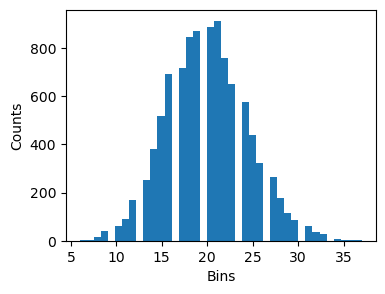

Numerical histogram

   Count     Bin value
     62  -->  6.00
    323  -->  9.10
   1151  -->  12.20
   2253  -->  15.30
   2669  -->  18.40
   1988  -->  21.50
   1025  -->  24.60
    384  -->  27.70
    126  -->  30.80
     19  -->  33.90


In [8]:
import random 

x=np.random.poisson(20, 10000)

plt.figure(figsize=(4,3))
plt.hist(x, 40)
plt.xlabel("Bins")
plt.ylabel("Counts")
plt.show()

count, values=np.histogram(x, 10)

print("Numerical histogram\n")
print("   Count     Bin value")
for ic, iv in zip(count, values):
    print(" %6i  -->  %4.2f" %  (ic, iv))

### The implementation of the Richter's fit

Here is the proposal.

The possibility has been added to select only those events whose magnitude is within a given range; the optional selection of events occurred in a specific depth interval is implemented as well.

Moreover, a graphical representation of the Richter's law is implemented (*richter_plot* method).


```
    def richter(self, mgm=0, mgx=0, d_min=0, d_max=0, bins=0, plot=False): 
 
        """
        Computes Richter's law fit
        
        Input:
             mgm: if not 0, minimum magnitude (default 0)
             mgx: if not 0, maximum magnitude (default 0)
             d_min: if not 0, minimum depth (default 0)
             d_max: if not 0, maximum depth (default 0)
             bins: if not 0, sets the number of bins of
                   the histogram of the magnitude distribution
                   (default 0)
             plot: if True, a plot of the Richter's law is produced
                   (default False)
        """
        self.richter_flag=False
        self.describe()
        
        if bins !=0:
           self.bins=bins
        
        minimum=np.min(self.magnitude)
        maximum=np.max(self.magnitude)     
        minimum_d=np.min(self.depth)
        maximum_d=np.max(self.depth)
        
        if mgm != 0:
           minimum=mgm
        if mgx != 0:
           maximum=mgx           
        if d_min != 0:
           minimum_d=d_min
        if d_max != 0:
           maximum_d=d_max 
        
        mag=self.magnitude 
        depth=self.depth
        
        cases_mag=np.where((mag >= minimum) & (mag <= maximum))
        cases_depth=np.where((depth >= minimum_d) & (depth <= maximum_d))
        cases=np.intersect1d(cases_mag, cases_depth)
        
        count, mag=np.histogram(mag[cases], bins=self.bins)          
        nz_counts=np.array([])
        nz_mag=np.array([])
        for ic in range(len(count)):
            if count[ic] != 0:
               nz_counts=np.append(nz_counts, count[ic])
               nz_mag=np.append(nz_mag, mag[ic])                    
        nz_log_counts=np.log10(nz_counts)         
        fit=np.polyfit(nz_mag, nz_log_counts, 1)
        
        self.richter_fit=fit
        self.nz_log_counts=nz_log_counts
        self.nz_mag=nz_mag        
        self.richter_flag=True
        
        print("Fit results:")
        print(f"Number of events: {len(cases)}")
        print("Intercept: %4.2f,   Slope: %6.4f" % (fit[1], fit[0]))
        
        if plot:
           self.richter_plot(mgm, mgx)
```

Below, the new method is incorporated within the *Data* class:

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class Stat():
          
      def set_size(self):
          self.size=len(self.magnitude)
          return self.size
        
      def average(self):
          ave = 0.
          size = self.set_size()
          self.size=size
          for ix in self.magnitude:
              ave=ave+ix
          ave=ave/size
          self.ave=ave
          self.flag=True
          return ave
        
      def standard_deviation(self, force=True):
          if (not self.flag) or (self.flag and force):
             ave=self.average() 
            
          ave=self.ave
          size=self.size
          std=0.
          for ix in self.magnitude:
              std=std+(ix-ave)**2
                
          std=(std/(size-1))**0.5
          self.std=std
          return std
            
      def describe(self):   
              
          self.average()
          self.standard_deviation()
          self.min_mag=np.min(self.magnitude)
          self.max_mag=np.max(self.magnitude)
          self.depth_min=np.min(self.depth)
          self.depth_max=np.max(self.depth)
                    
          print("data-set: %s" % self.name)
          print("Size: %4i" % self.size)
          print("Minimum magnitude:  %5.2f" % self.min_mag)
          print("Maximum magnitude:  %5.2f" % self.max_mag)
          print("Average magnitude:  %5.2f" % self.ave)
          print("Stand. dev:         %5.2f\n" % self.std)
          print("Depths (km):")
          print("Minimum depth: %6.1f, maximum depth %6.1f\n" %
                (self.depth_min, self.depth_max))
            
          if self.richter_flag:
             inter=self.richter_fit[1]
             slope=self.richter_fit[0]
             print("Richter fit:")
             print("Intercept: %4.2f,   Slope: %6.4f\n" % (inter, slope))
                
class Data(Stat):
    number_of_obj=0  
    obj_files=[]
    obj_names=[]
    flag_array=False
    bins=10
    
    def __init__(self, name):
        self.name=name       
        self.flag=True
        self.size=None
        self.richter_flag=False
        
    def set_data(self, type_of_data, val):
        
        match type_of_data:
            case 'magnitude':
               self.magnitude=np.array(val)
            
            case 'depth':
               self.depth=np.array(val)
               
            case other:
                print(f"{type_of_data} not implemented")
                
    def richter(self, mgm=0, mgx=0, d_min=0, d_max=0, bins=0, plot=False): 
 
        """
        Computes Richter's law fit
        
        Input:
             mgm: if not 0, minimun magnitude (default 0)
             mgx: if not 0, maximum magnitude (default 0)
             d_min: if not 0, minimum depth (default 0)
             d_max: if not 0, maximim depth (default 0)
             bins: if not 0, sets the number of bins of
                   the histogram of the magnitude distribution
                   (default 0)
             plot: if True, a plot of the Richter's law is produced
                   (default False)
        """
        self.richter_flag=False
        self.describe()
        
        if bins !=0:
           self.bins=bins
        
        minimum=np.min(self.magnitude)
        maximum=np.max(self.magnitude)     
        minimum_d=np.min(self.depth)
        maximum_d=np.max(self.depth)
        
        if mgm != 0:
           minimum=mgm
        if mgx != 0:
           maximum=mgx           
        if d_min != 0:
           minimum_d=d_min
        if d_max != 0:
           maximum_d=d_max 
        
        mag=self.magnitude 
        depth=self.depth
        
        cases_mag=np.where((mag >= minimum) & (mag <= maximum))
        cases_depth=np.where((depth >= minimum_d) & (depth <= maximum_d))
        cases=np.intersect1d(cases_mag, cases_depth)
        
        count, mag=np.histogram(mag[cases], bins=self.bins)          
        nz_counts=np.array([])
        nz_mag=np.array([])
        for ic in range(len(count)):
            if count[ic] != 0:
               nz_counts=np.append(nz_counts, count[ic])
               nz_mag=np.append(nz_mag, mag[ic])                    
        nz_log_counts=np.log10(nz_counts)         
        fit=np.polyfit(nz_mag, nz_log_counts, 1)
        
        self.richter_fit=fit
        self.nz_log_counts=nz_log_counts
        self.nz_mag=nz_mag        
        self.richter_flag=True
        
        print("Fit results:")
        print(f"Number of events: {len(cases)}")
        print("Intercept: %4.2f,   Slope: %6.4f" % (fit[1], fit[0]))
        
        if plot:
           self.richter_plot(mgm=mgm, mgx=mgx)
        
    def richter_plot(self, mgm=0, mgx=0, force=False):
        """
        Richter's law plot
        
        Input:
            mgm: if not 0, sets the minimim magnitude considered
            mgx: if not 0, sets the maximum magnitude considered
            force: if True, a Richter's law fit is requested 
                   (default False)
        """
        if force or (not self.richter_flag):
           self.richter(mgm, mgx, d_min=0, d_max=0)   
           fit=self.richter_fit
        
        mag_min=self.min_mag
        mag_max=self.max_mag
    
        if mgm != 0:
           mag_min=mgm
        if mgx != 0:
           mag_max=mgx
           
        p1x=mag_min
        p2x=mag_max    
        p1y=np.polyval(self.richter_fit, p1x)
        p2y=np.polyval(self.richter_fit, p2x)
    
        nz_mag=self.nz_mag
        nz_log_counts=self.nz_log_counts
       
        plt.figure(figsize=(4,3))
        plt.plot(nz_mag, nz_log_counts, "k*", label="Actual values")
        plt.plot((p1x, p2x), (p1y, p2y), "k-", label="Linear regression")        
        plt.xlabel('Magnitude')
        plt.ylabel('Log count')
        plt.title('Richter Law')
        plt.legend(frameon=False)
        plt.show()
        
        print("")
        
    def depth_distribution(self, bins=30):
        depth=self.depth

        plt.figure(figsize=(4,3))
        plt.hist(depth, bins)
        plt.xlabel("Depth (km)")
        plt.ylabel("Number")
        plt.title(f"Region: {self.name.capitalize()}")
        plt.show()
        
    @classmethod
    def set_bins(cls, new_bin):
        if new_bin <=2:
           new_bin=2
        
        cls.bins=new_bin
                  
    @classmethod
    def read_info(cls, path, info_file):         
        file=path+'/'+info_file
        fi=open(file)
        text=fi.read()
        fi.close()
        text=text.rstrip().splitlines()
        num_lines=len(text)
        cls.obj_names=[]
        cls.obj_files=[]
        cls.number_of_obj=num_lines
             
        for line in text:
            line=line.split()
            cls.obj_files.append(path+'/'+line[0])
            cls.obj_names.append(line[1])
            
    @classmethod
    def setup(cls):
        for obj, file in zip(cls.obj_names, cls.obj_files):
            idata=pd.read_csv(file, sep='|')
            idata.rename(columns={"Depth/Km": "Depth"}, inplace=True)
           
            if not cls.flag_array:
               try:
                  eval(obj).set_data('magnitude', idata.Magnitude)
                  eval(obj).set_data('depth', idata.Depth)
               except NameError:
                  print("Array method should be set as 'region variables'")
                  print("are not defined. Use the command:")
                  print(">>> Data.set_array()")
                  break
            else:
               ipos=cls.obj_dictionary[obj]               
               cls.obj_array[ipos].set_data('magnitude', idata.Magnitude)
               cls.obj_array[ipos].set_data('depth', idata.Depth)
               cls.obj_array[ipos].flag_ready=True           
                    
            
    @classmethod
    def set_array(cls, out=False): 
        
        cls.flag_array=True
        number_list=list(range(len(cls.obj_names)))
        l_set=list(iset for iset in cls.obj_names)        
        cls.obj_dictionary=dict(zip(cls.obj_names, number_list))
        cls.obj_array=np.array(number_list, dtype='object')
        
        for name in cls.obj_dictionary:
            ipos=cls.obj_dictionary[name]
            cls.obj_array[ipos]=cls(cls.obj_names[ipos])
            
        cls.setup()
        
        if out:
            return cls.obj_dictionary, cls.obj_array 
        
    @classmethod
    def describe_all(cls):
        print(f"Number of datasets: {cls.number_of_obj}")
        print(f"Regions: {cls.obj_names}\n")
        
        for obj in cls.obj_names:
            if not cls.flag_array:
                eval(obj).describe()
                print("")
            else:
                ipos=cls.obj_dictionary[obj]
                cls.obj_array[ipos].describe()
                print("")
                   
        print("-"*35)
            
    @classmethod
    def richter_all(cls, mgm=0, mgx=0, d_min=0, d_max=0, plot=False):
        for obj in cls.obj_names:
            if not cls.flag_array:
               eval(obj).richter(mgm, mgx, d_min, d_max, plot=plot)
               print("\n")
            else:
                ipos=cls.obj_dictionary[obj]
                cls.obj_array[ipos].richter(mgm, mgx, d_min, d_max, plot=plot)
                print("\n")
                
        print("")
        print("-"*35)        

Lets's try it by using the dataset in the array mode:

In [10]:
def start(path='L7_data_files', info='info.dat'):
    global rd, ra
    Data.read_info(path, info)
    for obj in Data.obj_names:
        exec(obj + ' = Data(obj)')
    
    rd, ra=Data.set_array(out=True)
    
start()

Have a look at whole dataset:

In [11]:
Data.describe_all()

Number of datasets: 5
Regions: ['sicilia', 'north', 'central', 'emilia', 'marche']

data-set: sicilia
Size:  559
Minimum magnitude:   2.00
Maximum magnitude:   4.30
Average magnitude:   2.33
Stand. dev:          0.35

Depths (km):
Minimum depth:    0.0, maximum depth  208.2


data-set: north
Size:  131
Minimum magnitude:   2.00
Maximum magnitude:   3.90
Average magnitude:   2.36
Stand. dev:          0.39

Depths (km):
Minimum depth:    1.5, maximum depth   62.4


data-set: central
Size:  367
Minimum magnitude:   2.00
Maximum magnitude:   3.90
Average magnitude:   2.29
Stand. dev:          0.34

Depths (km):
Minimum depth:    4.9, maximum depth   69.5


data-set: emilia
Size:  144
Minimum magnitude:   2.00
Maximum magnitude:   4.10
Average magnitude:   2.33
Stand. dev:          0.37

Depths (km):
Minimum depth:    1.1, maximum depth   71.1


data-set: marche
Size:  528
Minimum magnitude:   1.00
Maximum magnitude:   4.20
Average magnitude:   2.08
Stand. dev:          0.47

Depths (km):
M

With reference to the case of *sicilia*, let's see the depth distribution: 

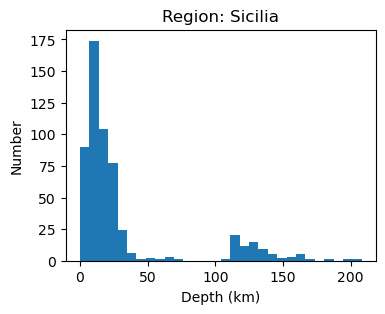

In [12]:
ra[rd['sicilia']].depth_distribution()

Then, do select only the events occurring at depths shallower than 50 km and make the Richter's fit:

data-set: sicilia
Size:  559
Minimum magnitude:   2.00
Maximum magnitude:   4.30
Average magnitude:   2.33
Stand. dev:          0.35

Depths (km):
Minimum depth:    0.0, maximum depth  208.2

Fit results:
Number of events: 476
Intercept: 4.48,   Slope: -1.1113


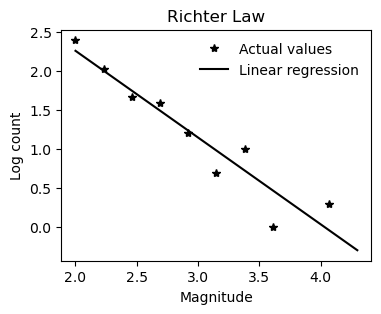

In [13]:
ra[rd['sicilia']].richter(d_max=50, plot=True)

data-set: sicilia
Size:  559
Minimum magnitude:   2.00
Maximum magnitude:   4.30
Average magnitude:   2.33
Stand. dev:          0.35

Depths (km):
Minimum depth:    0.0, maximum depth  208.2

Fit results:
Number of events: 472
Intercept: 4.51,   Slope: -1.0592


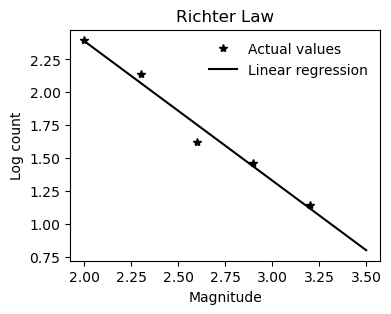

In [14]:
ra[rd['sicilia']].richter(mgx=3.5, d_max=50, bins=5, plot=True)

Below, the Richter's fit for the events at higher depths in Sicilia:

data-set: sicilia
Size:  559
Minimum magnitude:   2.00
Maximum magnitude:   4.30
Average magnitude:   2.33
Stand. dev:          0.35

Depths (km):
Minimum depth:    0.0, maximum depth  208.2

Fit results:
Number of events: 83
Intercept: 4.47,   Slope: -1.3724


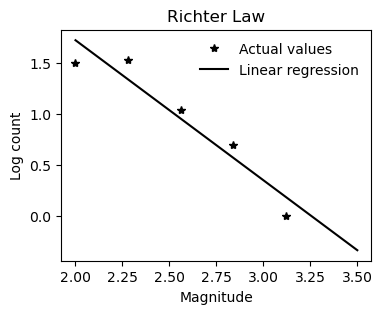

In [15]:
ra[rd['sicilia']].richter(mgx=3.5, d_min=50, bins=5, plot=True)

The fit can be done for all the created datasets, by using the class method *richter_all* 

Note below, that the class method *set_bins* is used to modify the value of the class attribute *bins*: this becomes the object attribute of every instance of the class *Data*, and determines the number of *channels* in the definition of the histogram of magnitude values 

data-set: sicilia
Size:  559
Minimum magnitude:   2.00
Maximum magnitude:   4.30
Average magnitude:   2.33
Stand. dev:          0.35

Depths (km):
Minimum depth:    0.0, maximum depth  208.2

Fit results:
Number of events: 559
Intercept: 5.02,   Slope: -1.2126


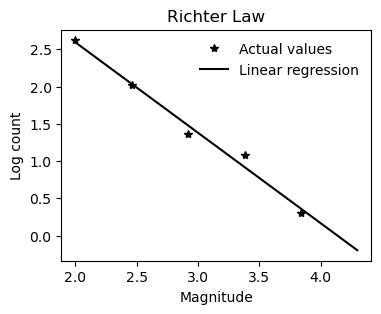




data-set: north
Size:  131
Minimum magnitude:   2.00
Maximum magnitude:   3.90
Average magnitude:   2.36
Stand. dev:          0.39

Depths (km):
Minimum depth:    1.5, maximum depth   62.4

Fit results:
Number of events: 131
Intercept: 3.76,   Slope: -0.9745


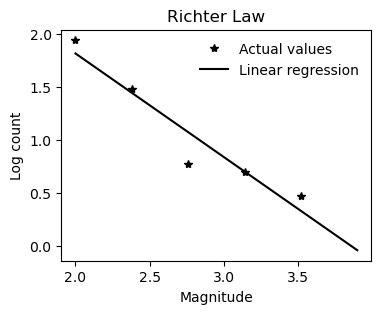




data-set: central
Size:  367
Minimum magnitude:   2.00
Maximum magnitude:   3.90
Average magnitude:   2.29
Stand. dev:          0.34

Depths (km):
Minimum depth:    4.9, maximum depth   69.5

Fit results:
Number of events: 367
Intercept: 5.14,   Slope: -1.3588


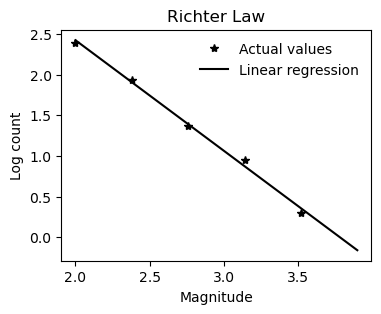




data-set: emilia
Size:  144
Minimum magnitude:   2.00
Maximum magnitude:   4.10
Average magnitude:   2.33
Stand. dev:          0.37

Depths (km):
Minimum depth:    1.1, maximum depth   71.1

Fit results:
Number of events: 144
Intercept: 4.08,   Slope: -1.0902


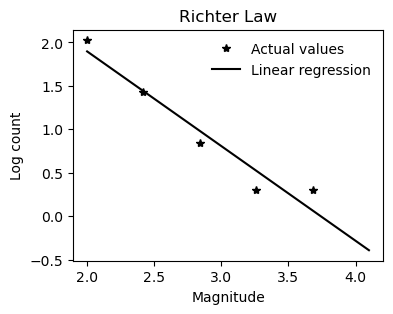




data-set: marche
Size:  528
Minimum magnitude:   1.00
Maximum magnitude:   4.20
Average magnitude:   2.08
Stand. dev:          0.47

Depths (km):
Minimum depth:    0.6, maximum depth   34.8

Fit results:
Number of events: 528
Intercept: 2.85,   Slope: -0.4997


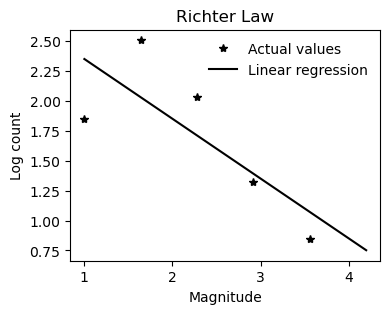





-----------------------------------


In [16]:
Data.set_bins(5)
Data.richter_all(plot=True)

Now, the class method *describe_all* also reports the data from the fits just perfomed:

In [17]:
Data.describe_all()

Number of datasets: 5
Regions: ['sicilia', 'north', 'central', 'emilia', 'marche']

data-set: sicilia
Size:  559
Minimum magnitude:   2.00
Maximum magnitude:   4.30
Average magnitude:   2.33
Stand. dev:          0.35

Depths (km):
Minimum depth:    0.0, maximum depth  208.2

Richter fit:
Intercept: 5.02,   Slope: -1.2126


data-set: north
Size:  131
Minimum magnitude:   2.00
Maximum magnitude:   3.90
Average magnitude:   2.36
Stand. dev:          0.39

Depths (km):
Minimum depth:    1.5, maximum depth   62.4

Richter fit:
Intercept: 3.76,   Slope: -0.9745


data-set: central
Size:  367
Minimum magnitude:   2.00
Maximum magnitude:   3.90
Average magnitude:   2.29
Stand. dev:          0.34

Depths (km):
Minimum depth:    4.9, maximum depth   69.5

Richter fit:
Intercept: 5.14,   Slope: -1.3588


data-set: emilia
Size:  144
Minimum magnitude:   2.00
Maximum magnitude:   4.10
Average magnitude:   2.33
Stand. dev:          0.37

Depths (km):
Minimum depth:    1.1, maximum depth   71.1

Rich

Let's have a more detailed look to the case of the *marche* dataset. It refers to the seismic sequence of November/December 2022 in that area (sea).  

data-set: marche
Size:  528
Minimum magnitude:   1.00
Maximum magnitude:   4.20
Average magnitude:   2.08
Stand. dev:          0.47

Depths (km):
Minimum depth:    0.6, maximum depth   34.8

Richter fit:
Intercept: 2.85,   Slope: -0.4997



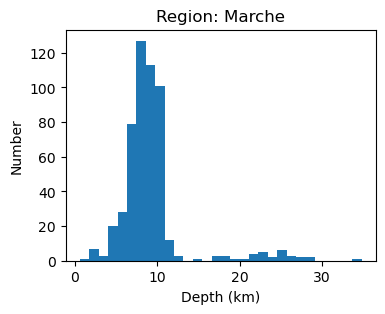

In [18]:
ra[rd["marche"]].describe()
ra[rd["marche"]].depth_distribution()

data-set: marche
Size:  528
Minimum magnitude:   1.00
Maximum magnitude:   4.20
Average magnitude:   2.08
Stand. dev:          0.47

Depths (km):
Minimum depth:    0.6, maximum depth   34.8

Fit results:
Number of events: 301
Intercept: 4.03,   Slope: -0.9672


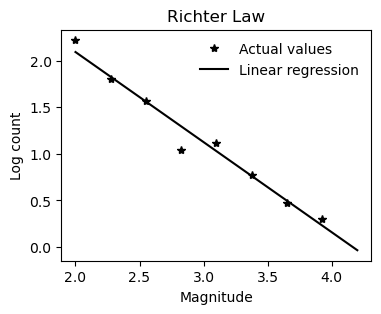

In [19]:
ra[rd["marche"]].richter(mgm=2., bins=8, plot=True)